### * **What is a phishing attack?**
* Phishing is a type of social engineering attack often used to steal user data, including login credentials and credit card numbers. It occurs when an attacker, masquerading as a trusted entity, dupes a victim into opening an email, instant message, or text message.

##### * Importing some useful libraries

In [24]:
!pip install selenium

In [25]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix

import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics
import matplotlib.pyplot as plt # It provides an object-oriented API for embedding plots into applications
%matplotlib inline
# It sets the backend of matplotlib to the 'inline' backend:
import time # calculate time

from sklearn.linear_model import LogisticRegression # algo use to predict good or bad
from sklearn.naive_bayes import MultinomialNB # nlp algo use to predict good or bad

from sklearn.model_selection import train_test_split # spliting the data between feature and target
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer # create sparse matrix of words using regexptokenizes
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos

from PIL import Image # getting images in notebook
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud

from bs4 import BeautifulSoup # use for scraping the data from website
from selenium import webdriver # use for automation chrome
import networkx as nx # for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

import pickle# use to dump model

import warnings # ignores pink warnings
warnings.filterwarnings('ignore')

* **Did some surfing and found some websites offering malicious links.** And found some datasets

* **Loading the main dataset.**

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
phish_data = pd.read_csv('/content/drive/MyDrive/p2/phishing_site_urls.csv')

In [28]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [29]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [30]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


* **About dataset**
* Data is containg 5,49,346 unique entries.
* There are two columns.
* Label column is prediction col which has 2 categories
    A. Good - which means the urls is not containing malicious stuff and **this site is not a Phishing Site.**
    B. Bad - which means the urls contains malicious stuffs and **this site isa Phishing Site.**
* There is no missing value in the dataset.

In [31]:
phish_data.isnull().sum() # there is no missing values

URL      0
Label    0
dtype: int64

* **Since it is classification problems so let's see the classes are balanced or imbalances**

In [32]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(phish_data.Label.value_counts())

<Axes: xlabel='Label', ylabel='count'>

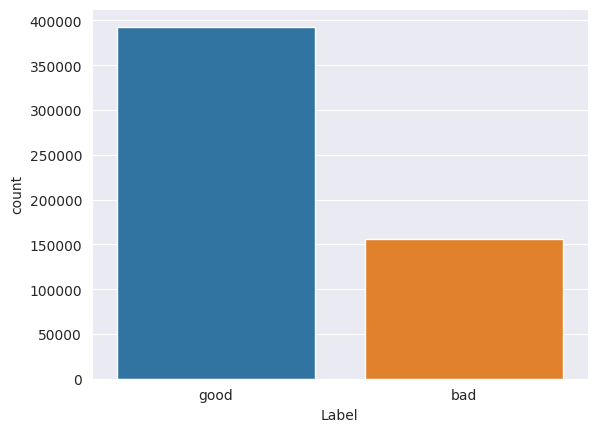

In [36]:
import seaborn as sns

# Visualizing target_col
sns.set_style('darkgrid')
sns.barplot(x=label_counts.index, y=label_counts['count'])


### Preprocessing

* **Now that we have the data, we have to vectorize our URLs. I used CountVectorizer and gather words using tokenizer, since there are words in urls that are more important than other words e.g ‘virus’, ‘.exe’ ,’.dat’ etc. Lets convert the URLs into a vector form.**

#### RegexpTokenizer
* A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.

In [37]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [38]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [39]:
# this will be pull letter which matches to expression
tokenizer.tokenize(phish_data.URL[0]) # using first row

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [40]:
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 4.111842670999977 sec


In [41]:
phish_data.sample(5)

,URL,Label,text_tokenized
366076,johnankerberg.org/catalog/NACC.html,good,"[johnankerberg, org, catalog, NACC, html]"
545493,hwnvcsstakbpmku.org/checkupdate,bad,"[hwnvcsstakbpmku, org, checkupdate]"
515072,webdav.hidrive.strato.com/users/oncole3991,bad,"[webdav, hidrive, strato, com, users, oncole]"
73810,www.tldp.org/HOWTO/Programming-Languages.html,good,"[www, tldp, org, HOWTO, Programming, Languages..."
440766,superpages.com/bp/Kansas-City-MO/Elmwood-Cemet...,good,"[superpages, com, bp, Kansas, City, MO, Elmwoo..."


#### SnowballStemmer
* Snowball is a small string processing language, gives root words

In [42]:
stemmer = SnowballStemmer("english") # choose a language

In [43]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 53.36144461399999 sec


In [44]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed
208532,lmtribune.com/blogs/all_points_bulletin/articl...,good,"[lmtribune, com, blogs, all, points, bulletin,...","[lmtribun, com, blog, all, point, bulletin, ar..."
88126,www.roundhillsoftware.com/MessageCleaner/,good,"[www, roundhillsoftware, com, MessageCleaner]","[www, roundhillsoftwar, com, messageclean]"
175426,en.wikipedia.org/wiki/Harry_Wolverton,good,"[en, wikipedia, org, wiki, Harry, Wolverton]","[en, wikipedia, org, wiki, harri, wolverton]"
498509,bisericaromaneasca.ro/jzvtuc,bad,"[bisericaromaneasca, ro, jzvtuc]","[bisericaromaneasca, ro, jzvtuc]"
35875,gillrice.com/paypal.com.cgi-bin-webscr-cmd-log...,bad,"[gillrice, com, paypal, com, cgi, bin, webscr,...","[gillric, com, paypal, com, cgi, bin, webscr, ..."


In [ ]:
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.2757654860000116 sec


In [ ]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
52715,www.fdic.gov/news/news/financial/2007/fil07083...,good,"[www, fdic, gov, news, news, financial, fil, h...","[www, fdic, gov, news, news, financi, fil, html]",www fdic gov news news financi fil html
363206,ioffer.com/i/12151817,good,"[ioffer, com, i]","[ioffer, com, i]",ioffer com i
198592,howmanyofme.com/people/Lori_Saunders/,good,"[howmanyofme, com, people, Lori, Saunders]","[howmanyofm, com, peopl, lori, saunder]",howmanyofm com peopl lori saunder
140956,agoracom.com/ir/Crystallex/forums/discussion/t...,good,"[agoracom, com, ir, Crystallex, forums, discus...","[agoracom, com, ir, crystallex, forum, discuss...",agoracom com ir crystallex forum discuss topic...
435133,spiritus-temporis.com/index/fre.html,good,"[spiritus, temporis, com, index, fre, html]","[spiritus, tempori, com, index, fre, html]",spiritus tempori com index fre html


### Visualization
**1. Visualize some important keys using word cloud**

In [ ]:
#sliceing classes
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [ ]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [ ]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


* create a function to visualize the important keys from url

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from wordcloud import ImageColorGenerator

def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0),
                   title=None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words=max_words,
                          max_font_size=max_font_size,
                          random_state=42,
                          mask=mask)
    wordcloud.generate(text)

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size, 'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
# common_text = str(data)
# common_mask = np.array(Image.open('star.png'))
# plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120, title='Most common words use in good urls', title_size=15)


In [ ]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

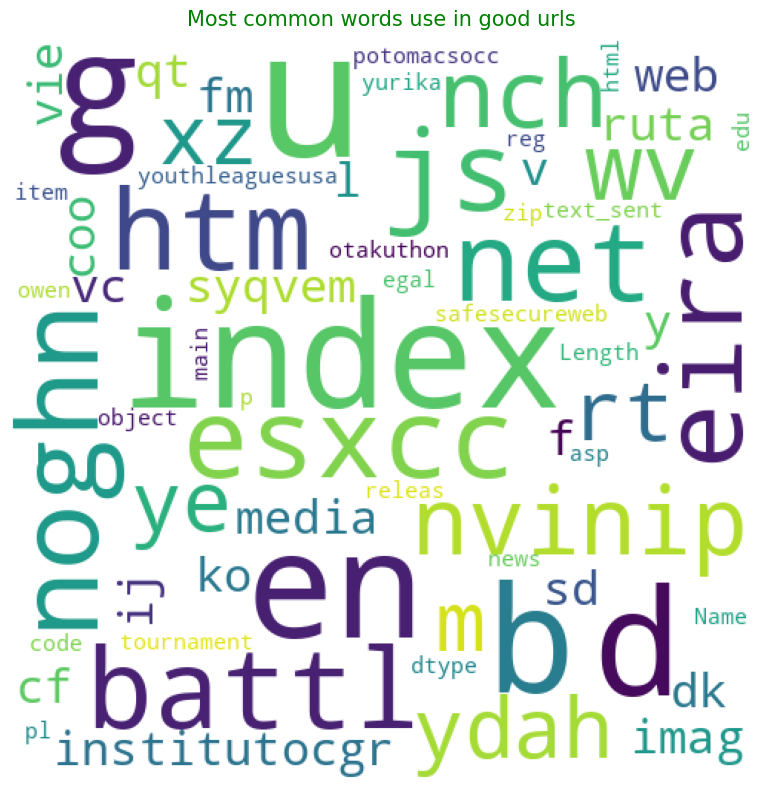

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import string
import os
from wordcloud import WordCloud, STOPWORDS

# Define a function to generate a word cloud
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(12.0,8.0),
                   title=None, title_size=40, image_color=False):
    # Define stopwords
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    # Generate word cloud
    wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words=max_words,
                          max_font_size=max_font_size,
                          random_state=42,
                          mask=mask)
    wordcloud.generate(text)

    # Plot word cloud
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size, 'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
common_text = str(data)

# Create a black image
image = np.zeros((500, 500))

# Save the image as 'star.png'
plt.imsave('star.png', image)

common_mask = np.array(Image.open('star.png'))

plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120, title='Most common words use in good urls', title_size=15)

In [ ]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [ ]:
!pip install wordcloud

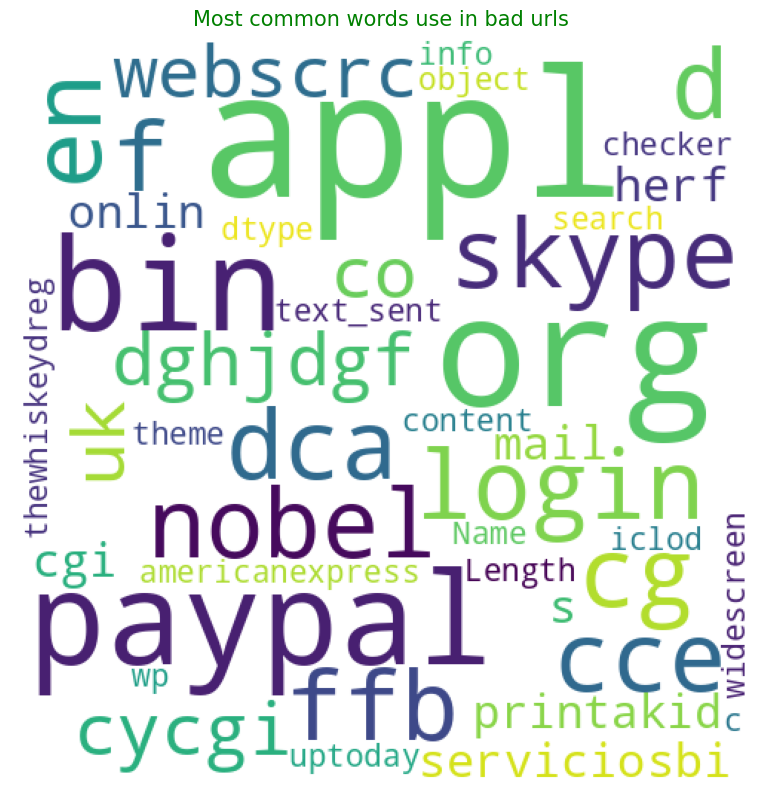

In [ ]:
# common_text = str(data)
# common_mask = np.array(Image.open('comment.png'))
# plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120,
#                title = 'Most common words use in bad urls', title_size=15)






import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import string
import os
from wordcloud import WordCloud, STOPWORDS

# Define a function to generate a word cloud
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(12.0,8.0),
                   title=None, title_size=40, image_color=False):
    # Define stopwords
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    # Generate word cloud
    wordcloud = WordCloud(background_color='white',
                          stopwords=stopwords,
                          max_words=max_words,
                          max_font_size=max_font_size,
                          random_state=42,
                          mask=mask)
    wordcloud.generate(text)

    # Plot word cloud
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size, 'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
common_text = str(data)

# Create a black image with higher resolution
image = np.zeros((500, 500))

# Save the image as 'comment.png'
plt.imsave('comment.png', image)

common_mask = np.array(Image.open('comment.png'))

plot_wordcloud(common_text, common_mask, max_words=400, max_font_size=120,
               title = 'Most common words use in bad urls', title_size=15)

**2. Visualize internal links, it will shows all redirect links.**

#### Scrape any website
* First, setting up the Chrome webdriver so we can scrape dynamic web pages.

#### Chrome webdriver
* WebDriver tool use for automated testing of webapps across many browsers. It provides capabilities for navigating to web pages, user input and more

In [ ]:
pip install selenium


In [ ]:
# browser = webdriver.Chrome(r"chromedriver.exe")

from selenium import webdriver

# Create a ChromeOptions object
options = webdriver.ChromeOptions()

# Set the path to the chromedriver executable
options.binary_location = r"chromedriver.exe"

# Set the headless mode
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")

# Create a Chrome browser instance
browser = webdriver.Chrome(options=options)

# Navigate to a webpage
browser.get("https://www.google.com")

# Print the page title
print(browser.title)

# Close the browser
browser.quit()

Google


* After set up the Chrome driver create two lists.
* First list named list_urls holds all the pages you’d like to scrape.
* Second, create an empty list where you’ll append links from each page.


In [ ]:
list_urls = ['https://www.ezeephones.com/','https://www.ezeephones.com/about-us'] #here i take phishing sites
links_with_text = []

* I took some phishing site to see were the hackers redirect(on different link) us.
* Use the BeautifulSoup library to extract only relevant hyperlinks for Google, i.e. links only with '<'a'>' tags with href attributes.

#### BeautifulSoup
* It is use for getting data out of HTML, XML, and other markup languages.

In [ ]:
# for url in list_urls:
#     browser.get(url)
#     soup = BeautifulSoup(browser.page_source,"html.parser")
#     for line in soup.find_all('a'):
#         href = line.get('href')
#         links_with_text.append([url, href])



import time
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup

# Define the list of URLs
list_urls = ['https://www.example.com', 'https://www.example2.com']

# Initialize the webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-gpu')
options.add_argument('--remote-debugging-address=0.0.0.0')
options.add_argument('--remote-debugging-ws-address=0.0.0.0:32773')
options.add_argument('--remote-debugging-http-address=0.0.0.0:9222')
options.add_argument('--remote-debugging-port=9222')
options.add_argument('--remote-debugging-no-default-browser-check')
options.add_argument('--remote-debugging-log-level=0')

browser = webdriver.Chrome(options=options)

# Loop through the list of URLs
for url in list_urls:
    try:
        # Navigate to the URL
        browser.get(url)

        # Wait for the page to load
        WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))

        # Parse the page source with BeautifulSoup
        soup = BeautifulSoup(browser.page_source, "html.parser")

        # Extract all links with text
        links = soup.find_all('a', href=True)
        for link in links:
            print(link['href'])

    except Exception as e:
        print(f"An error occurred: {e}")



https://www.iana.org/domains/example


#### Turn the URL’s into a Dataframe
* After you get the list of your websites with hyperlinks turn them into a Pandas DataFrame with columns “from” (URL where the link resides) and “to” (link destination URL)

In [ ]:
df = pd.DataFrame(links_with_text, columns=["from", "to"])

In [ ]:
df.head()

,from,to


#### Step 3: Draw a graph
* Finally, use the aforementioned DataFrame to **visualize an internal link structure by feeding it to the Networkx method from_pandas_edgelist first** and draw it by calling nx.draw

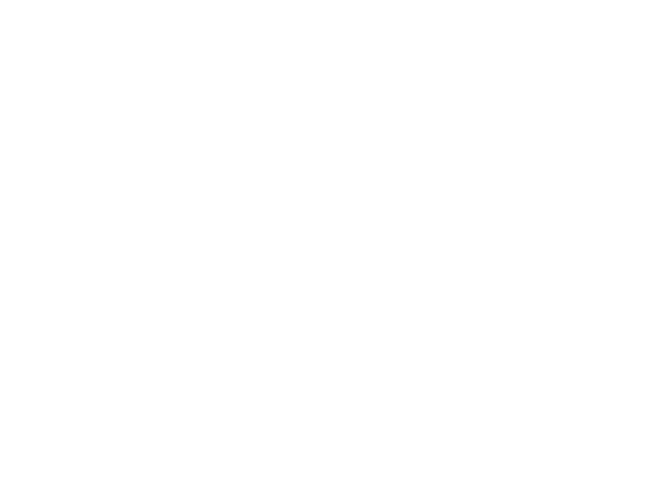

In [ ]:
 GA = nx.from_pandas_edgelist(df, source="from", target="to")
 nx.draw(GA, with_labels=False)






### Creating Model

#### CountVectorizer
* CountVectorizer is used to transform a corpora of text to a vector of term / token counts.

In [ ]:
#create cv object
cv = CountVectorizer()

In [ ]:
#help(CountVectorizer())

In [ ]:
feature = cv.fit_transform(phish_data.text_sent) #transform all text which we tokenize and stemed

In [ ]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### * Spliting the data

In [ ]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

### LogisticRegression
* Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [ ]:
# create lr object
lr = LogisticRegression()

In [ ]:
lr.fit(trainX,trainY)

LogisticRegression()

In [ ]:
lr.score(testX,testY)

0.9627194419566468

.*** Logistic Regression is giving 96% accuracy, Now we will store scores in dict to see which model perform best**

In [ ]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9773281651614406
Testing Accuracy : 0.9627194419566468

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.90      0.96      0.93     36821
        Good       0.99      0.96      0.97    100516

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


<Axes: >

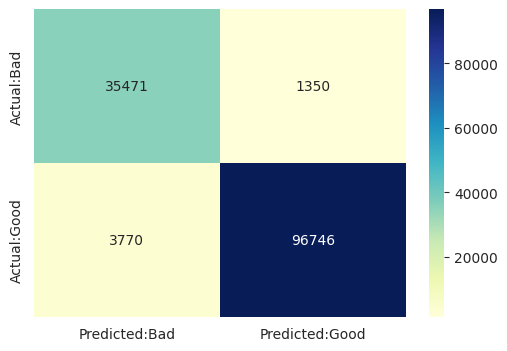

In [ ]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### MultinomialNB
* Applying Multinomial Naive Bayes to NLP Problems. Naive Bayes Classifier Algorithm is a family of probabilistic algorithms based on applying Bayes' theorem with the “naive” assumption of conditional independence between every pair of a feature.

In [ ]:
# create mnb object
mnb = MultinomialNB()

In [ ]:
mnb.fit(trainX,trainY)

MultinomialNB()

In [ ]:
mnb.score(testX,testY)

0.9573093922249649

*** MultinomialNB gives us 95% accuracy**  

In [ ]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

In [ ]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

Training Accuracy : 0.9739860051600815
Testing Accuracy : 0.9573093922249649

CLASSIFICATION REPORT



In [ ]:
# acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
# sns.set_style('darkgrid')
# sns.barplot(acc.index,acc.Accuracy)




import pandas as pd
import seaborn as sns

# Create the DataFrame
acc = pd.DataFrame.from_dict(Scores_ml, orient='index', columns=['Accuracy'])

# Set the style
sns.set_style('darkgrid')

# Plot the bar plot
sns.barplot(x=acc.index, y=acc.Accuracy, data=acc)

*** So, Logistic Regression is the best fit model, Now we make sklearn pipeline using Logistic Regression**

In [ ]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())
##(r'\b(?:http|ftp)s?://\S*\w|\w+|[^\w\s]+') ([a-zA-Z]+)([0-9]+) -- these tolenizers giving me low accuray

In [ ]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [ ]:
pipeline_ls.score(testX,testY)

0.9647946292696069

Training Accuracy : 0.979718889635906
Testing Accuracy : 0.9647946292696069

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36770
        Good       0.99      0.96      0.98    100567

    accuracy                           0.96    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.96      0.97    137337


CONFUSION MATRIX


<Axes: >

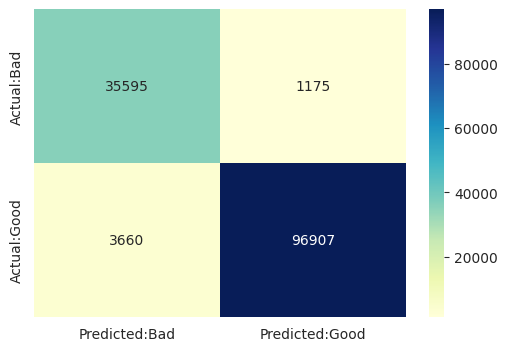

In [ ]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9664839045559463


***That’s it. See, it's that simple yet so effective. We get an accuracy of 98%. That’s a very high value for a machine to be able to detect a malicious URL with. Want to test some links to see if the model gives good predictions? Sure. Let's do it**

In [ ]:
# * Bad links => this are phishing sites
# yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php
# fazan-pacir.rs/temp/libraries/ipad
# www.tubemoviez.exe
# svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt

# * Good links => this are not phishing sites
# www.youtube.com/
# youtube.com/watch?v=qI0TQJI3vdU
# www.retailhellunderground.com/
# restorevisioncenters.com/html/technology.html




# Bad links (phishing sites)
bad_links = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php',
             'fazan-pacir.rs/temp/libraries/ipad',
             'www.tubemoviez.exe',
             'svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']

# Good links (non-phishing sites)
good_links = ['www.youtube.com/',
              'youtube.com/watch?v=qI0TQJI3vdU',
              'www.retailhellunderground.com/',
              'restorevisioncenters.com/html/technology.html']

In [ ]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','retailhellunderground.com/','restorevisioncenters.com/html/technology.html','yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'bad' 'good' 'good' 'bad']


### Protections
#### How to Protect Your Computer
Below are some key steps to protecting your computer from intrusion:

1. **Keep Your Firewall Turned On:** A firewall helps protect your computer from hackers who might try to gain access to crash it, delete information, or even steal passwords or other sensitive information. Software firewalls are widely recommended for single computers. The software is prepackaged on some operating systems or can be purchased for individual computers. For multiple networked computers, hardware routers typically provide firewall protection.

2. **Install or Update Your Antivirus Software:** Antivirus software is designed to prevent malicious software programs from embedding on your computer. If it detects malicious code, like a virus or a worm, it works to disarm or remove it. Viruses can infect computers without users’ knowledge. Most types of antivirus software can be set up to update automatically.

3. **Install or Update Your Antispyware Technology:** Spyware is just what it sounds like—software that is surreptitiously installed on your computer to let others peer into your activities on the computer. Some spyware collects information about you without your consent or produces unwanted pop-up ads on your web browser. Some operating systems offer free spyware protection, and inexpensive software is readily available for download on the Internet or at your local computer store. Be wary of ads on the Internet offering downloadable antispyware—in some cases these products may be fake and may actually contain spyware or other malicious code. It’s like buying groceries—shop where you trust.

4. **Keep Your Operating System Up to Date:** Computer operating systems are periodically updated to stay in tune with technology requirements and to fix security holes. Be sure to install the updates to ensure your computer has the latest protection.

5. **Be Careful What You Download:** Carelessly downloading e-mail attachments can circumvent even the most vigilant anti-virus software. Never open an e-mail attachment from someone you don’t know, and be wary of forwarded attachments from people you do know. They may have unwittingly advanced malicious code.

6. **Turn Off Your Computer:** With the growth of high-speed Internet connections, many opt to leave their computers on and ready for action. The downside is that being “always on” renders computers more susceptible. Beyond firewall protection, which is designed to fend off unwanted attacks, turning the computer off effectively severs an attacker’s connection—be it spyware or a botnet that employs your computer’s resources to reach out to other unwitting users.

https://research.aalto.fi/en/datasets/phishstorm-phishing-legitimate-url-dataset